In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torch
import torchvision.transforms.functional as F
import torchvision.models.detection as detection
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from PIL import Image
from ultralytics import YOLO
import time
import os

# Object detection using YOLO 

In [5]:
# Load YOLO model
model_YOLO = YOLO("yolov8m.pt")

In [6]:
# Load images
image_paths = [
    "bench.jpg",
    "cars_on_freeway.jpg",
    "cycling.jpg",
    "freeway.jpg",
    "horse.jpg",
    "monkey.jpeg",
    "monkey2.jpg",
    "people.jpg",
    "sheep.jpg",
    "squirrel.jpg",
]

In [7]:
def get_basic_image_info(image_path):
    """Get basic image information (width, height, aspect ratio, average brightness)"""
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    aspect_ratio = width / height
    arr = np.array(img)
    avg_brightness = float(arr.mean())  # 0–255 roughly
    return width, height, aspect_ratio, avg_brightness

In [8]:
yolo_results_rows = []

confidence_threshold = 0.5   # filter low-confidence detections

for image_path in image_paths:
    print(f"Running YOLO on {image_path}...")
    
    # Extra info about the image (for the “anything else” question)
    width, height, aspect_ratio, avg_brightness = get_basic_image_info(image_path)
    
    # Measure time
    start_time = time.time()
    results = model_YOLO.predict(image_path, verbose=False)
    elapsed = time.time() - start_time
    
    result = results[0]
    boxes = result.boxes
    
    # Filter detections by confidence threshold
    confidences = []
    labels = []
    for box in boxes:
        conf = float(box.conf[0].item())
        if conf >= confidence_threshold:
            confidences.append(conf)
            class_id = int(box.cls[0].item())
            labels.append(result.names[class_id])
    
    # Record image details for printing
    num_detections = len(confidences)
    avg_conf = float(np.mean(confidences)) if num_detections > 0 else 0.0
    max_conf = float(np.max(confidences)) if num_detections > 0 else 0.0
    unique_classes = len(set(labels))

    # Appending the results for comparison later
    yolo_results_rows.append({
        "image": os.path.basename(image_path),
        "model": "YOLOv8m",
        "num_detections": num_detections,
        "avg_confidence": round(avg_conf, 3),
        "max_confidence": round(max_conf, 3),
        "unique_classes": unique_classes,
        "classes_detected": list(set(labels)),
        "inference_time_sec": round(elapsed, 3),
        "width": width,
        "height": height,
        "aspect_ratio": round(aspect_ratio, 3),
        "avg_brightness": round(avg_brightness, 1),
    })

print("Done!")

Running YOLO on bench.jpg...
Running YOLO on cars_on_freeway.jpg...
Running YOLO on cycling.jpg...
Running YOLO on freeway.jpg...
Running YOLO on horse.jpg...
Running YOLO on monkey.jpeg...
Running YOLO on monkey2.jpg...
Running YOLO on people.jpg...
Running YOLO on sheep.jpg...
Running YOLO on squirrel.jpg...
Done!


### View one image result from YOLO

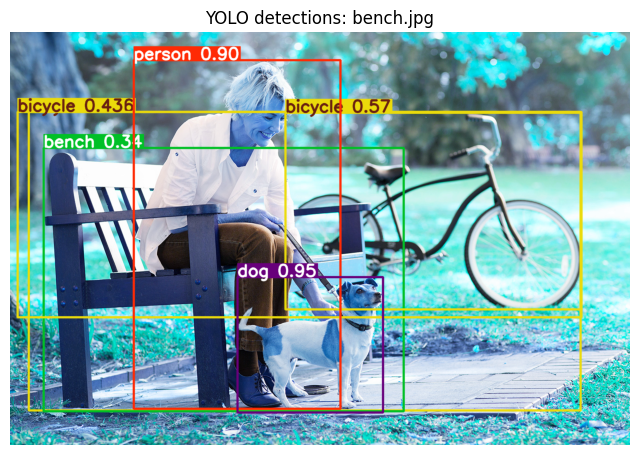

In [9]:
test_image = image_paths[0] 

results = model_YOLO.predict(test_image, verbose=False)
result = results[0]

annotated = result.plot()
plt.figure(figsize=(8, 6))
plt.imshow(annotated)
plt.axis("off")
plt.title(f"YOLO detections: {os.path.basename(test_image)}")
plt.show()

# Object detection using Faster R-CNN 

In [10]:
# Load metadata for pre-trained Faster R-CNN model (COCO classes)
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
COCO_CLASSES = weights.meta["categories"]

print("Number of COCO classes:", len(COCO_CLASSES))
print("Some example classes:", COCO_CLASSES[:10])

Number of COCO classes: 91
Some example classes: ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat']


### Load the pre-trained Faster R-CNN model

In [11]:
model = detection.fasterrcnn_resnet50_fpn(weights=weights)
model.eval()  # inference mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [12]:
faster_results_rows = []

score_threshold = 0.5  # filter low-confidence detections

for image_path in image_paths:
    print(f"Running Faster R-CNN on {image_path}...")
    
    # Extra info about the image
    width, height, aspect_ratio, avg_brightness = get_basic_image_info(image_path)
    
    # Load image and convert to tensor
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image)  # C x H x W
    
    # Measure time
    start_time = time.time()
    with torch.no_grad():
        outputs = model([image_tensor])
    elapsed = time.time() - start_time
    
    output = outputs[0]
    scores = output["scores"]
    labels_idx = output["labels"]
    boxes = output["boxes"]
    
    # Apply score threshold
    keep = scores >= score_threshold
    scores = scores[keep]
    labels_idx = labels_idx[keep]
    boxes = boxes[keep]

    # Record image details for printing
    num_detections = int(scores.shape[0])
    confidences = scores.tolist()
    avg_conf = float(np.mean(confidences)) if num_detections > 0 else 0.0
    max_conf = float(np.max(confidences)) if num_detections > 0 else 0.0
    labels = [COCO_CLASSES[int(i)] for i in labels_idx.tolist()]
    unique_classes = len(set(labels))
    
    #  Appending the results for comparison later
    faster_results_rows.append({
        "image": os.path.basename(image_path),
        "model": "FasterRCNN_ResNet50_FPN",
        "num_detections": num_detections,
        "avg_confidence": round(avg_conf, 3),
        "max_confidence": round(max_conf, 3),
        "unique_classes": unique_classes,
        "classes_detected": list(set(labels)), 
        "inference_time_sec": round(elapsed, 3),
        "width": width,
        "height": height,
        "aspect_ratio": round(aspect_ratio, 3),
        "avg_brightness": round(avg_brightness, 1),
    })

print("Done!")

Running Faster R-CNN on bench.jpg...
Running Faster R-CNN on cars_on_freeway.jpg...
Running Faster R-CNN on cycling.jpg...
Running Faster R-CNN on freeway.jpg...
Running Faster R-CNN on horse.jpg...
Running Faster R-CNN on monkey.jpeg...
Running Faster R-CNN on monkey2.jpg...
Running Faster R-CNN on people.jpg...
Running Faster R-CNN on sheep.jpg...
Running Faster R-CNN on squirrel.jpg...
Done!


### View one image result from Faster R-CNN

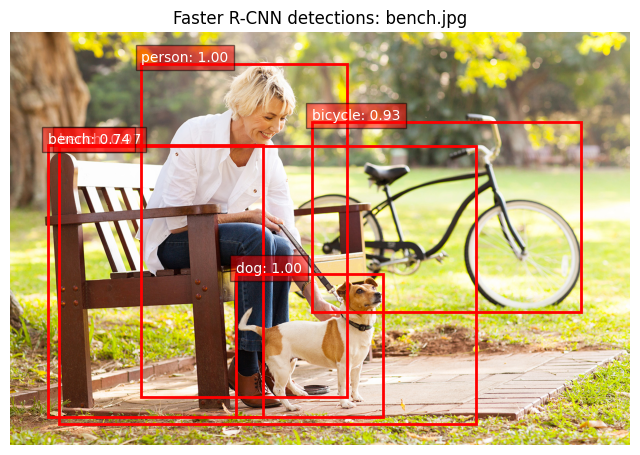

In [13]:
test_image = image_paths[0]

image = Image.open(test_image).convert("RGB")
image_tensor = F.to_tensor(image)

with torch.no_grad():
    outputs = model([image_tensor])

output = outputs[0]
scores = output["scores"]
labels_idx = output["labels"]
boxes = output["boxes"]

score_threshold = 0.5
keep = scores >= score_threshold
scores = scores[keep]
labels_idx = labels_idx[keep]
boxes = boxes[keep]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(image)

for box, score, label_idx in zip(boxes, scores, labels_idx):
    x_min, y_min, x_max, y_max = box.tolist()
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

    class_name = COCO_CLASSES[int(label_idx)]
    ax.text(
        x_min,
        y_min - 5,
        f"{class_name}: {float(score):.2f}",
        color='white',
        fontsize=10,
        bbox=dict(facecolor='red', alpha=0.5)
    )

plt.axis("off")
plt.title(f"Faster R-CNN detections: {os.path.basename(test_image)}")
plt.show()

# Combining YOLO and Faster R-CNN 

In [14]:
all_rows = yolo_results_rows + faster_results_rows
df_results = pd.DataFrame(all_rows)
df_results

,image,model,num_detections,avg_confidence,max_confidence,unique_classes,classes_detected,inference_time_sec,width,height,aspect_ratio,avg_brightness
0,bench.jpg,YOLOv8m,3,0.806,0.946,3,"[dog, bicycle, person]",0.173,1500,1000,1.500,153.5
1,cars_on_freeway.jpg,YOLOv8m,18,0.671,0.854,1,[car],0.129,1200,900,1.333,77.3
2,cycling.jpg,YOLOv8m,4,0.850,0.945,3,"[car, bicycle, person]",0.109,1024,683,1.499,130.9
3,freeway.jpg,YOLOv8m,7,0.760,0.915,1,[car],0.089,1280,720,1.778,134.8
4,horse.jpg,YOLOv8m,2,0.906,0.918,1,[horse],0.085,1024,615,1.665,139.0
5,monkey.jpeg,YOLOv8m,1,0.951,0.951,1,[bear],0.206,3000,4390,0.683,85.6
6,monkey2.jpg,YOLOv8m,1,0.897,0.897,1,[person],0.098,1200,675,1.778,61.2
7,people.jpg,YOLOv8m,4,0.850,0.932,3,"[dog, handbag, person]",0.120,960,640,1.500,92.6
8,sheep.jpg,YOLOv8m,1,0.960,0.960,1,[sheep],0.092,1200,800,1.500,147.0
9,squirrel.jpg,YOLOv8m,0,0.000,0.000,0,[],0.095,640,435,1.471,90.3


# Output Dataframe as a PNG or CSV

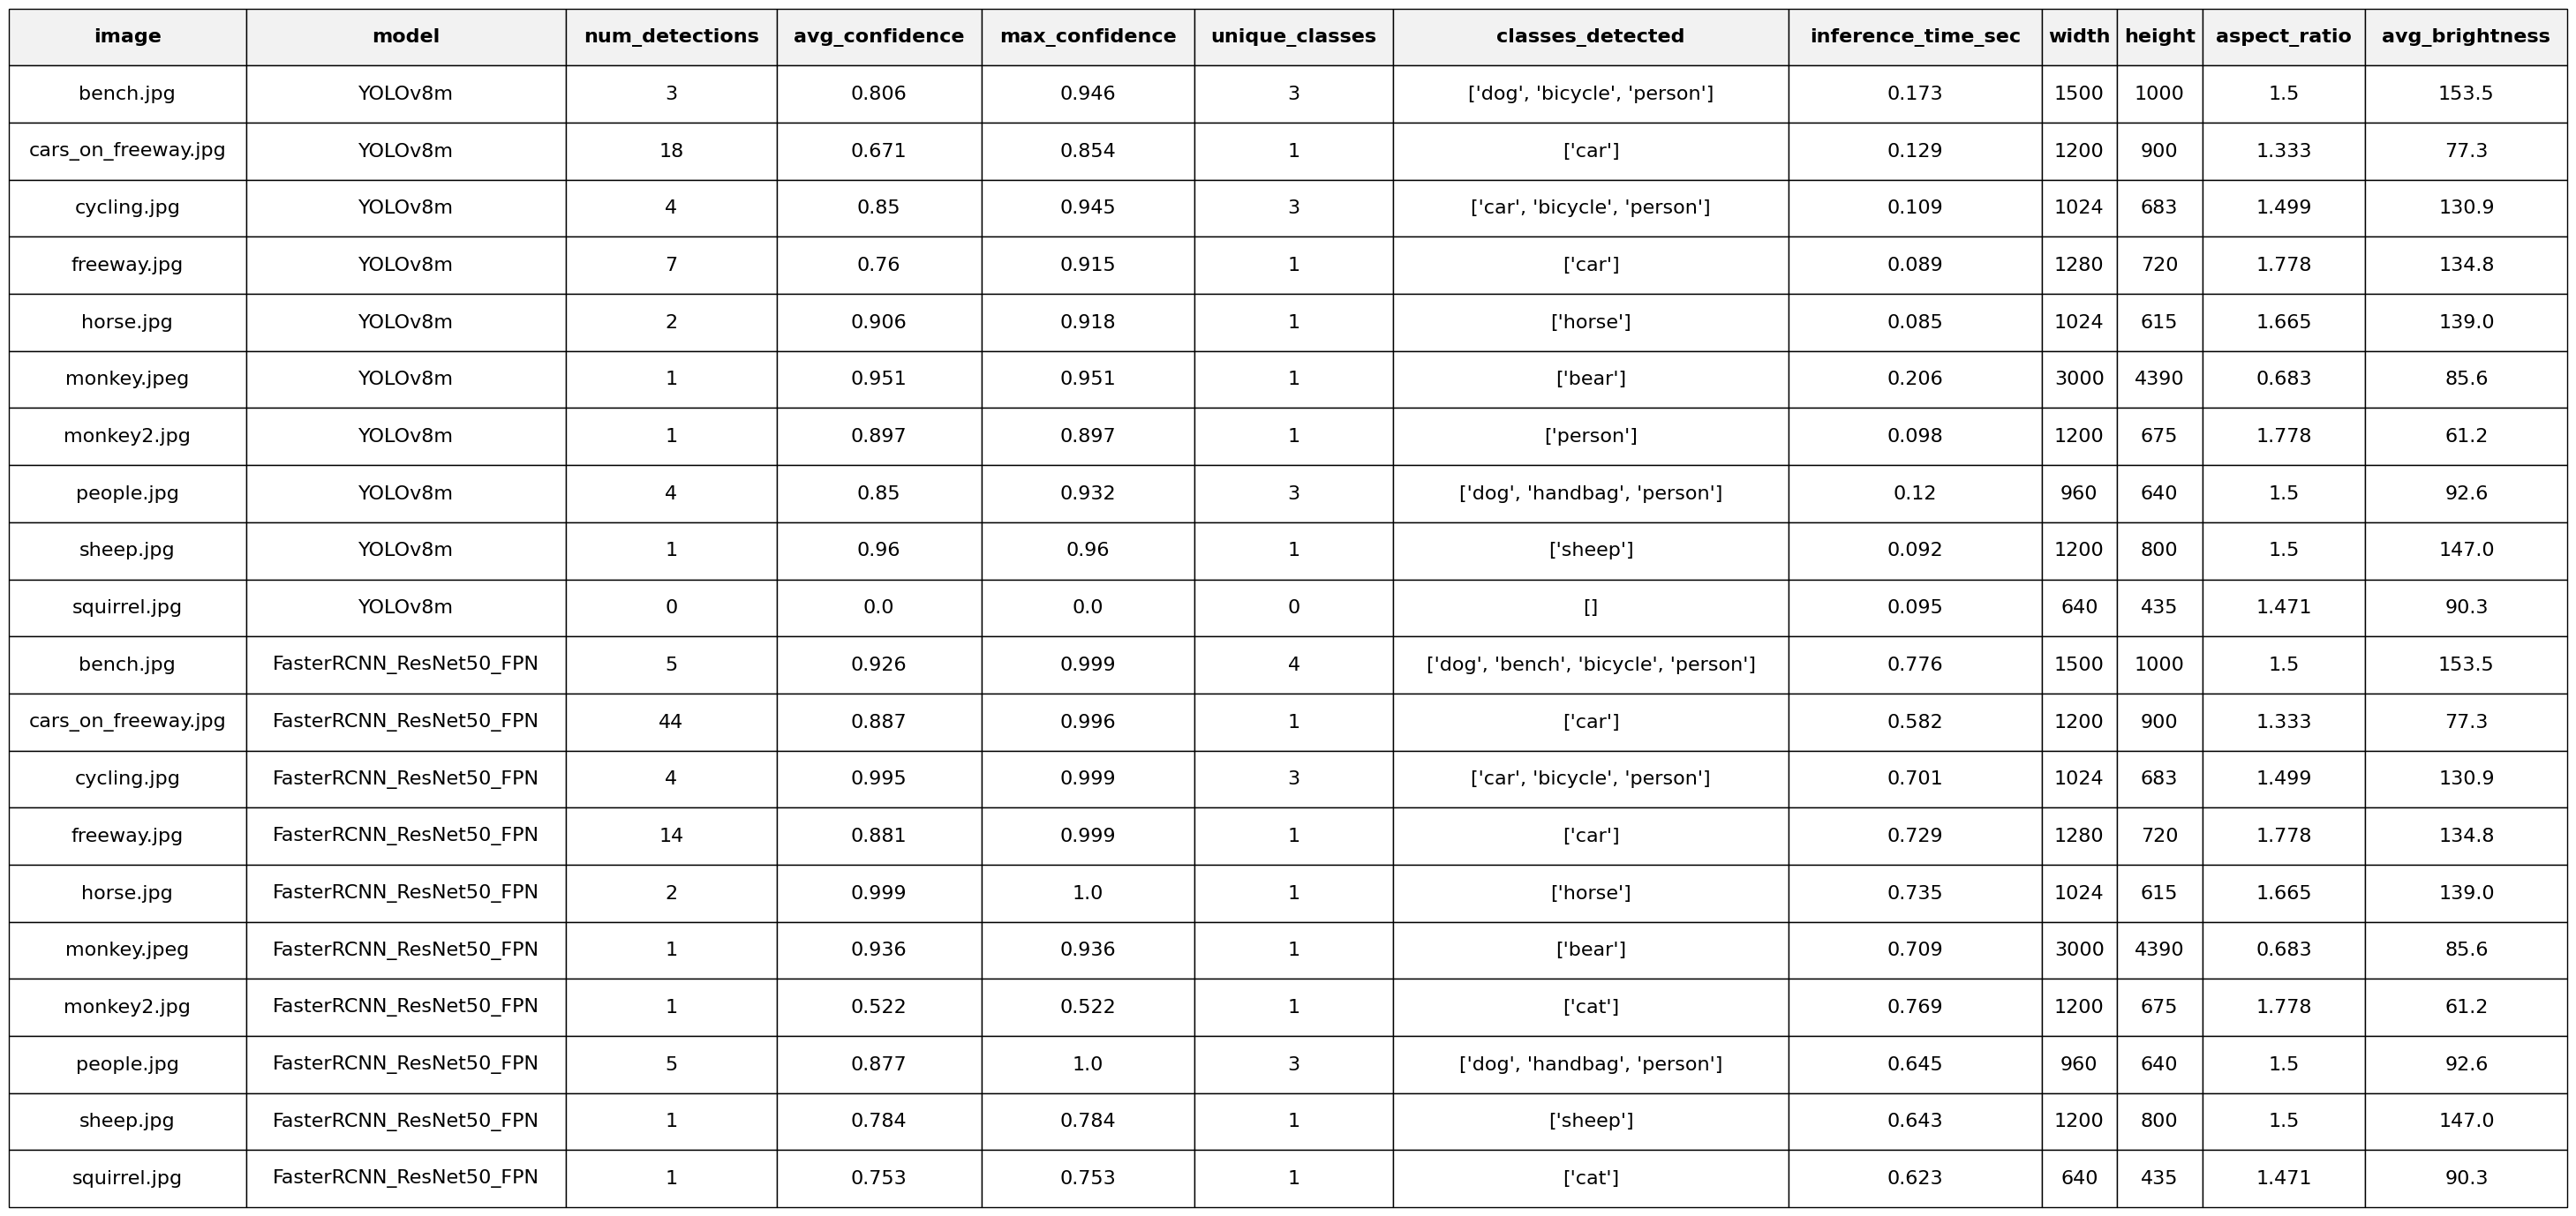

In [29]:
# Uncomment to output the df as a csv
# df_results.to_csv("object_detection_comparison.csv", index=False)

# Create a large figure so text is bigger
fig, ax = plt.subplots(figsize=(22, 14))   # Increase this for bigger text

ax.axis("off")

# Create the table
table = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    cellLoc="center",
    loc="center"
)

# Increase text size
table.auto_set_font_size(False)
table.set_fontsize(16)            # Make this bigger for larger text (try 16, 18)

# Auto-adjust column widths
table.auto_set_column_width(col=list(range(len(df_results.columns))))

# Make rows taller so text isn't squished
for key, cell in table.get_celld().items():
    cell.set_height(0.06)         # Increase row height
    if key[0] == 0:               # Header row
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#f2f2f2")

# Save image
# plt.savefig("df_results.png", dpi=300, bbox_inches="tight")
plt.show()